### Project goal: accuracy > 98.1% on independent test set, reduction of loss function fluctation using regularization
#### Change activation function (ELU)
#### Momentum optimizer
#### Add He inicialization
#### Add Clip values
#### Add Dropout

### Project goal: accuracy > 98.1% on independent test set

#### Tensorflow v > 2 but using compat.v1 (transition code)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import random
import tensorflow.compat.v1 as tf
from tensorflow.keras.datasets.mnist import load_data
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
import os
from scipy.stats import reciprocal
from datetime import datetime

#### Pobranie danych przez API-keras

In [2]:
(X_train, y_train), (X_test, y_test) = load_data()

In [3]:
def reshape_data(X):
    return X.reshape(X.shape[0], -1)

In [4]:
X_train_re, X_test_re = reshape_data(X_train), reshape_data(X_test)
X_train_re, X_test_re = X_train_re.astype(float), X_test_re.astype(float)

#### Wizualizacja przykladowych danych

In [5]:
print('Ilosc przykladow uczacych:', len(X_train))
print('Ilosc przykladow testowych:', len(X_test))

Ilosc przykladow uczacych: 60000
Ilosc przykladow testowych: 10000


In [6]:
def plot_digit(X, y, n = None):
    if not n:
        n = random.randint(0, len(X))
    digit, label = X[n], y[n]
    plt.imshow(digit, cmap = matplotlib.cm.binary, interpolation = 'nearest')
    plt.axis('off')
    plt.title("Label:" + str(label))
    plt.show()

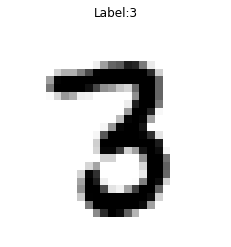

In [7]:
plot_digit(X = X_train, y = y_train)

#### Reset grafu

In [8]:
import random
def reset_graph():
    tf.reset_default_graph()
    seed = random.randint(1, 500)
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [9]:
reset_graph()

#### Model

In [16]:
class DNNMiniBatchEarlyStoppingTF:
    """
    """
    def __init__(self, n_epochs, layers = [300, 100, 10], batch_size = 100, dropout_rate = 0.025, threshold = 1, learning_rate_init = 0.004, learning_rate_range = (0.003,0.008), n_iterations = 5):
        self.n_epochs = n_epochs
        self.layers = layers
        self.threshold = threshold
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.learning_rate_init = learning_rate_init
        self.learning_rate_range = learning_rate_range
        self.n_iterations = n_iterations
        self.checkpoint_path = "./tmp/model.ckpt"
        self.checkpoint_epoch_path = self.checkpoint_path + ".epoch"
        self.checkpoint_lr_path = self.checkpoint_path + ".lr"
        self.final_model_path = "./final_model/model_final.model"
        if not os.path.isdir("./tmp"):
            os.mkdir("./tmp")
            
    def random_batch(self, X_train, y_train, batch_size):
        rnd_indices = np.random.randint(0, len(X_train), batch_size)
        X_batch = X_train[rnd_indices]
        y_batch = y_train[rnd_indices]
        return X_batch, y_batch
    
    def log_dir(self, prefix=""):
        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        root_logdir = "./log"
        if prefix:
            prefix += "-"
        name = prefix + "-" + now
        return "{}/{}/".format(root_logdir, name)
    
    def net(self, X, y, seed = 77, learning_rate = 0.01):
        """
        Model - stworzenie grafu obliczen.
        """
        n_inputs = int(X.get_shape()[1])
        he_init = tf.keras.initializers.VarianceScaling()
        training = tf.placeholder_with_default(False, shape=(), name='train_f')
        with tf.name_scope("DNN_Model"):
            with tf.name_scope("net"):
                for layer, i in zip(self.layers[:-1], range(len(self.layers[:-1]))):
                    X = tf.layers.dense(X, layer, name = "hidden" + str(i), kernel_initializer = he_init)
                    X = tf.layers.dropout(X, self.dropout_rate, training = training)
                    X = tf.layers.batch_normalization(X, training=training, momentum=0.9)
                    X = tf.nn.elu(X)
                logits = tf.layers.dense(X, self.layers[-1], kernel_initializer = he_init, name = 'logits') # Bez softmax bo jest zaimplementowana juz w loss function  
                logits = tf.layers.batch_normalization(logits, training=training, momentum=0.9)
            with tf.name_scope("loss"):
                xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits)
                loss = tf.reduce_mean(xentropy, name = "loss")
                loss_summary = tf.summary.scalar('loss', loss)
            with tf.name_scope("learning"):
                optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum = 0.9, use_nesterov = True)
                grads_and_vars = optimizer.compute_gradients(loss)
                capped_gvs = [(tf.clip_by_value(grad, -self.threshold, self.threshold), var)
                              for grad, var in grads_and_vars]
                training_op = optimizer.apply_gradients(capped_gvs)
            with tf.name_scope("eval"):
                correct = tf.nn.in_top_k(logits, y, 1)
                accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
                accuracy_summary = tf.summary.scalar('accuracy', accuracy)
            with tf.name_scope("init"):
                init = tf.global_variables_initializer()
            with tf.name_scope("save"):
                saver = tf.train.Saver(max_to_keep = 1000000)                        
        return training_op, loss, loss_summary, accuracy, accuracy_summary, init, saver
                               
    def train(self, X_train, y_train, X_test, y_test):
        """
        X_* - numpy ndarray
        y_* - numpy ndarray
        """
        
        # wczytanie danych z checkpointu dla optymalizacji learning_rate
        # lub inicjalizacja danych poczatkowych
        if os.path.isfile(self.checkpoint_epoch_path):
            with open(self.checkpoint_lr_path, 'r') as f:
                dt = f.read().split(',')
                start_iterations = int(dt[0])
                lr_best = float(dt[1])
                acc_best = float(dt[2])
                print('Uczenie wznowione od przebiegu:', start_iterations + 1, '\tNajlepszy lr', lr_best, '\tNajlepsze accuracy', acc_best)
        else:
            start_iterations = 0
            lr_best = 0
            acc_best = 0
            
        n_batches = int(np.ceil(X_train.shape[0] / self.batch_size))
        n_inputs = int(X_train.shape[1])
        

        for iteration in range(start_iterations, self.n_iterations):

            with tf.Session() as sess:
                
                # folder logu - dane do tensorboard
                logdir = self.log_dir('log')
                file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
                
                best_loss = np.infty
                epochs_without_progress = 0
                max_epochs_without_progress = 100
                
                if iteration == 0:
                    lr = self.learning_rate_init
                else:
                    lr = reciprocal(self.learning_rate_range[0], self.learning_rate_range[1]).rvs(random_state = iteration)

                print('Przebieg:', iteration + 1)
                print('    Logdir:', logdir)
                print('    Learning rate:', lr)

                with open(self.checkpoint_lr_path, 'w') as f:
                    f.write("%d, %s, %s" % (iteration, lr_best, acc_best))

                X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
                y = tf.placeholder(tf.int32, shape=(None), name="y")
                training_op, loss, loss_summary, accuracy, accuracy_summary, init, saver = self.net(X, y, learning_rate = lr)                

                if os.path.isfile(self.checkpoint_epoch_path):
                    with open(self.checkpoint_epoch_path, 'rb') as f:
                        start_epoch = int(f.read())
                    print('Uczenie wznowione od epoki:', start_epoch)
                    saver.restore(sess, self.checkpoint_path)
                else:
                    start_epoch = 0
                    sess.run(init)
                
                for epoch in range(start_epoch, self.n_epochs):
                    for batch_index in range(n_batches):
                        X_batch, y_batch = self.random_batch(X_train, y_train, self.batch_size)
                        sess.run(training_op, feed_dict = {X : X_batch, y : y_batch})
                               
                    accuracy_val, loss_val, accuracy_summary_str, loss_summary_str = sess.run([accuracy, loss, accuracy_summary, loss_summary], feed_dict={X: X_test, y: y_test})
                    file_writer.add_summary(loss_summary_str, epoch)
                    file_writer.add_summary(accuracy_summary_str, epoch)
                    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
                               
                    if epoch % 10 == 0 and epoch != 0:
                        print('        Epoka:', epoch, '\tLoss:', loss_val, '\tAccuracy:', acc_test)
                        saver.save(sess, self.checkpoint_path)
                        with open(self.checkpoint_epoch_path, 'wb') as f:
                             f.write(b"%d" % (epoch + 1))
                               
                    # Early stopping 
                    if epoch % 50 == 0:
                        if loss_val < best_loss:
                            best_loss = loss_val
                            epochs_without_progress = 0
                        else:
                            epochs_without_progress += 50
                            if epochs_without_progress > max_epochs_without_progress:
                                print('        Wczesne zatrzymywanie... ')
                                print('        Epoka:', epoch, '\tLoss:', loss_val, '\tAccuracy:', acc_test)
                                saver.save(sess, self.checkpoint_path)
                                with open(self.checkpoint_epoch_path, 'wb') as f:
                                     f.write(b"%d" % (epoch + 1))
                                break
                            

                accuracy_val = sess.run([accuracy], feed_dict={X: X_test, y: y_test})

                if accuracy_val[0] > acc_best:
                    # Problem z zapisywaniem modelu
                    saver.save(sess, self.final_model_path)
                    lr_best = lr
                    acc_best = accuracy_val[0]

                os.remove(self.checkpoint_epoch_path)        
                print('    Final iteration accuracy:', accuracy_val[0])
        
            tf.reset_default_graph()

        os.remove(self.checkpoint_lr_path)
        self.acc_best = acc_best
        self.lr_best = lr_best
        print('Final accuracy:', acc_best, 'Learning rate:', lr_best)
        
    def predict(self, X_score):
        """
        IN: X_score - numpy ndarray
        OUT: ndarray 
        """
        with tf.Session() as sess:
            saver = tf.train.import_meta_graph(self.final_model_path + '.meta')
            saver.restore(sess, self.final_model_path)
            graph = tf.get_default_graph()
            X = graph.get_tensor_by_name("X:0")
            y = graph.get_tensor_by_name("y:0")
            logits_ = graph.get_tensor_by_name("DNN_Model/net/logits/BiasAdd:0")
            feed_dict = {X : X_score}
            logits = sess.run(logits_, feed_dict = feed_dict)
            result = tf.nn.softmax(logits, name='softmax').eval()
            return [np.argmax(obs) for obs in result]

In [17]:
model = DNNMiniBatchEarlyStoppingTF(n_epochs = 501, layers = [1000, 500, 250, 150,  10], n_iterations = 5)

In [18]:
tf.reset_default_graph()
model.train(X_train = X_train_re, y_train = y_train, X_test = X_test_re, y_test = y_test)

Przebieg: 1
    Logdir: ./log/log--20201021130146/
    Learning rate: 0.004
        Epoka: 10 	Loss: 0.09796133 	Accuracy: 0.9773
        Epoka: 20 	Loss: 0.11143364 	Accuracy: 0.9768
        Epoka: 30 	Loss: 0.10949971 	Accuracy: 0.9815
        Epoka: 40 	Loss: 0.11681877 	Accuracy: 0.9838
        Epoka: 50 	Loss: 0.120898195 	Accuracy: 0.9838
        Epoka: 60 	Loss: 0.12324914 	Accuracy: 0.9839
        Epoka: 70 	Loss: 0.12557329 	Accuracy: 0.9841
        Epoka: 80 	Loss: 0.12703443 	Accuracy: 0.984
        Epoka: 90 	Loss: 0.12834005 	Accuracy: 0.984
        Epoka: 100 	Loss: 0.12960526 	Accuracy: 0.984
        Epoka: 110 	Loss: 0.13057698 	Accuracy: 0.984
        Epoka: 120 	Loss: 0.13147424 	Accuracy: 0.984
        Epoka: 130 	Loss: 0.13229163 	Accuracy: 0.9838
        Epoka: 140 	Loss: 0.13302109 	Accuracy: 0.9838
        Epoka: 150 	Loss: 0.13372387 	Accuracy: 0.9838
        Epoka: 160 	Loss: 0.1343757 	Accuracy: 0.9838
        Epoka: 170 	Loss: 0.13497624 	Accuracy: 0.9836
   

In [13]:
pred = model.predict(X_test_re)

INFO:tensorflow:Restoring parameters from ./final_model/model_final.model


In [14]:
def plot_digit(X, y, pred, n = None):
    if not n:
        n = random.randint(0, len(X))
    digit, label, pred = X[n], y[n], pred[n]
    plt.imshow(digit, cmap = matplotlib.cm.binary, interpolation = 'nearest')
    plt.axis('off')
    plt.title("Label:" + str(label) + " Pred:" + str(pred))
    plt.show()

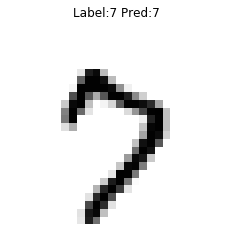

In [15]:
plot_digit(X = X_test, y = y_test, pred = pred, n = None)

### Projec goal has been archieved (accuracy: ~ 98.4 %)